# Brain Tumor Detection using CNN
This notebook implements a Convolutional Neural Network (CNN) to classify brain MRI images into **Tumor** and **No Tumor** categories.

Dataset structure:
- `brain_tumor_dataset/yes/` → Images with tumor
- `brain_tumor_dataset/no/` → Images without tumor


In [27]:

# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [28]:
import os

print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())


Current working directory: c:\DATASCIENCE\Code\Projects\BrainTumorDetection_CNN\Notebook
Contents: ['best_model.h5', 'best_model.keras', 'BrainTumorDataset.ipynb', 'Brain_Tumor_CNN.ipynb', 'Brain_Tumor_CNN_TransferLearning.ipynb', 'cnn_model.h5', 'images']


## Data Loading & Preprocessing

In [29]:

# Dataset path (single folder with "yes" and "no")
data_path = "C:/DATASCIENCE/Code/Projects/BrainTumorDetection_CNN/Data/brain_tumor_dataset"

# Image settings
img_size = 150
batch_size = 32

# ✅ Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
    validation_split=0.2   # 20% for validation
)

# ✅ Training generator
train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

# ✅ Validation generator (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=False
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## CNN Model

In [30]:

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer="Adam",  
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [31]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# ✅ Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# Evaluate best model
best_model = tf.keras.models.load_model("best_model.keras")
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best Model Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5074 - loss: 0.8814 - val_accuracy: 0.6200 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 981ms/step - accuracy: 0.6108 - loss: 0.6740 - val_accuracy: 0.6200 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6010 - loss: 0.6589 - val_accuracy: 0.6200 - val_loss: 0.5906 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 780ms/step - accuracy: 0.6355 - loss: 0.6260 - val_accuracy: 0.7200 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 800ms/step - accuracy: 0.6108 - loss: 0.6430 - val_accuracy: 0.6400 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 782ms/step - accuracy: 0.6650 - loss: 0.6345 - val_accuracy: 0.7800 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 718ms/step - accuracy: 0.6552 - loss: 0.6326 - val_accuracy: 0.7200

## Model Evaluation

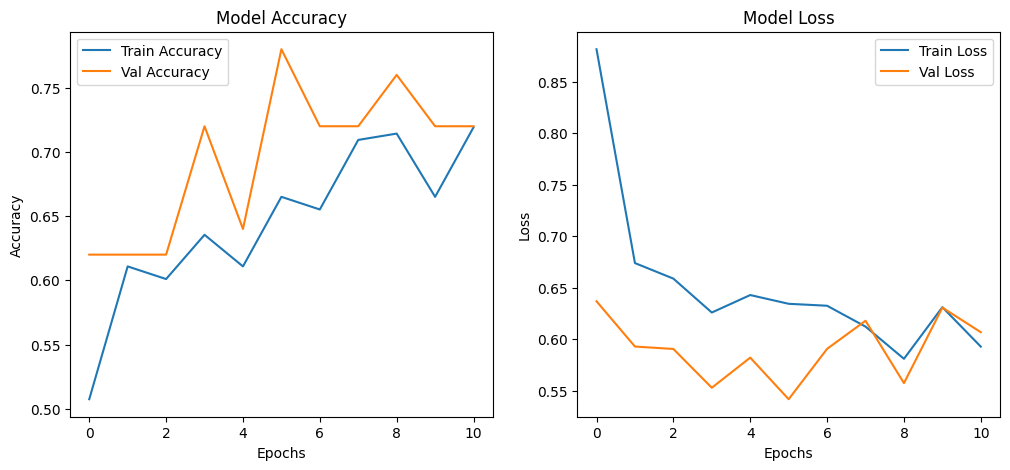

In [32]:
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig("images/accuracy_plot.png")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig("images/loss.png")
plt.legend()

plt.show()


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023CBA4196C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


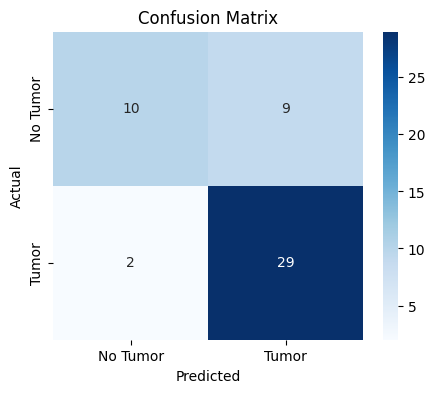

              precision    recall  f1-score   support

    No Tumor       0.83      0.53      0.65        19
       Tumor       0.76      0.94      0.84        31

    accuracy                           0.78        50
   macro avg       0.80      0.73      0.74        50
weighted avg       0.79      0.78      0.77        50



In [33]:

# Predictions for confusion matrix
val_gen.reset()
y_pred = (model.predict(val_gen) > 0.5).astype("int32")
y_true = val_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Tumor','Tumor'], yticklabels=['No Tumor','Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix.png")
plt.show()


# Classification report
print(classification_report(y_true, y_pred, target_names=['No Tumor','Tumor']))


## Save Model

In [34]:

# Save the trained CNN model
model.save("cnn_model.h5")
print("Model saved as cnn_model.h5")


Model saved as cnn_model.h5
